In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

plt.style.use("seaborn-v0_8-whitegrid")


In [3]:
macro_df = pd.read_excel("Macro.xlsx")
ship_df  = pd.read_excel("Market Shipments.xlsx")

print("Macro shape:", macro_df.shape)
print("Shipments shape:", ship_df.shape)


Macro shape: (2282, 12)
Shipments shape: (1675, 4)


In [4]:
# ---- Fix region for USA & Canada ----
macro_df.loc[macro_df["Country"].isin(["USA", "Canada"]), "Datos Region"] = "NA"

# ---- Clean Year column ----
# Convert to numeric (floats), turn bad values into NaN
macro_df["Year"] = pd.to_numeric(macro_df["Year"], errors="coerce")

# Drop rows where Year is missing
macro_df = macro_df.dropna(subset=["Year"])

# Cast to int
macro_df["Year"] = macro_df["Year"].astype(int)

# ---- Keep only 2022–2030 ----
macro_df = macro_df[macro_df["Year"].between(2022, 2030)].copy()

print("Macro years after filter:", sorted(macro_df["Year"].unique()))

# ---- Sort for interpolation ----
macro_df = macro_df.sort_values(["Country", "Year"]).reset_index(drop=True)

# ---- Make numeric / interpolate macro columns ----
macro_num_cols = [
    "Employed persons", "Population",
    "FiscalBalance_pctGDP", "Debt_pctGDP",
    "Savings_pctGDP", "GDP_real_growth",
    "CapitalFormation_pctGDP"
]

for c in macro_num_cols:
    macro_df[c] = pd.to_numeric(macro_df[c], errors="coerce")

for c in macro_num_cols:
    macro_df[c] = macro_df.groupby("Country")[c].transform(
        lambda s: s.interpolate(limit_direction="both")
    )

print("Remaining NaNs in macro numeric columns:")
print(macro_df[macro_num_cols].isna().sum())


Macro years after filter: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025), np.int64(2026), np.int64(2027), np.int64(2028), np.int64(2029), np.int64(2030)]
Remaining NaNs in macro numeric columns:
Employed persons           1244
Population                    0
FiscalBalance_pctGDP          0
Debt_pctGDP                  18
Savings_pctGDP               54
GDP_real_growth               0
CapitalFormation_pctGDP      78
dtype: int64


In [5]:
# ---- Fix region for USA & Canada ----
ship_df.loc[ship_df["Country"].isin(["USA", "Canada"]), "Datos Region"] = "NA"

# ---- Clean Year column ----
ship_df["Year"] = pd.to_numeric(ship_df["Year"], errors="coerce")
ship_df = ship_df.dropna(subset=["Year"])
ship_df["Year"] = ship_df["Year"].astype(int)

# ---- Keep only 2022–2030 to match macro ----
ship_df = ship_df[ship_df["Year"].between(2022, 2030)].copy()

# ---- Ensure Market Shipments is numeric ----
ship_df["Market Shipments"] = pd.to_numeric(
    ship_df["Market Shipments"], errors="coerce"
)

ship_df = ship_df.sort_values(["Country", "Year"]).reset_index(drop=True)

print("Shipments years after filter:", sorted(ship_df["Year"].unique()))
print("Ship_df shape:", ship_df.shape)


Shipments years after filter: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025), np.int64(2026), np.int64(2027), np.int64(2028), np.int64(2029), np.int64(2030)]
Ship_df shape: (1675, 4)


In [6]:
merge_keys = ["Country", "Datos Region", "Year"]

data = pd.merge(macro_df, ship_df, on=merge_keys, how="left")
print("Merged shape:", data.shape)
data.head()


Merged shape: (3336, 13)


,Country Macro,Country,Datos Region,Year,SCALE,Employed persons,Population,FiscalBalance_pctGDP,Debt_pctGDP,Savings_pctGDP,GDP_real_growth,CapitalFormation_pctGDP,Market Shipments
0,Albania,Albania,CEE,2022,Units,NaN,2778000.0,-3.639,65.1980,19.8280,4.8270,27.6370,NaN
1,Albania,Albania,CEE,2022,NaN,NaN,2778000.0,-3.639,65.1980,21.4575,4.4210,25.7820,NaN
2,Albania,Albania,CEE,2023,Units,NaN,2764000.0,-2.479,61.5865,23.0870,4.0150,23.9270,NaN
3,Albania,Albania,CEE,2023,NaN,NaN,2750000.0,-1.319,57.9750,22.5110,4.0305,24.7185,NaN
4,Albania,Albania,CEE,2024,Units,NaN,2736000.0,-1.022,57.0025,21.9350,4.0460,25.5100,NaN


# Rows where we have Market Shipments
train_data = data[data["Market Shipments"].notna()].copy()

# Train only on historical years 2022–2024
train_data = train_data[train_data["Year"].between(2022, 2024)].copy()

print("Training years:", sorted(train_data["Year"].unique()))
print("Train shape:", train_data.shape)


In [7]:
# Rows where we have Market Shipments
train_data = data[data["Market Shipments"].notna()].copy()

# Train only on historical years 2022–2024
train_data = train_data[train_data["Year"].between(2022, 2024)].copy()

print("Training years:", sorted(train_data["Year"].unique()))
print("Train shape:", train_data.shape)


Training years: [np.int64(2022), np.int64(2023), np.int64(2024)]
Train shape: (696, 13)


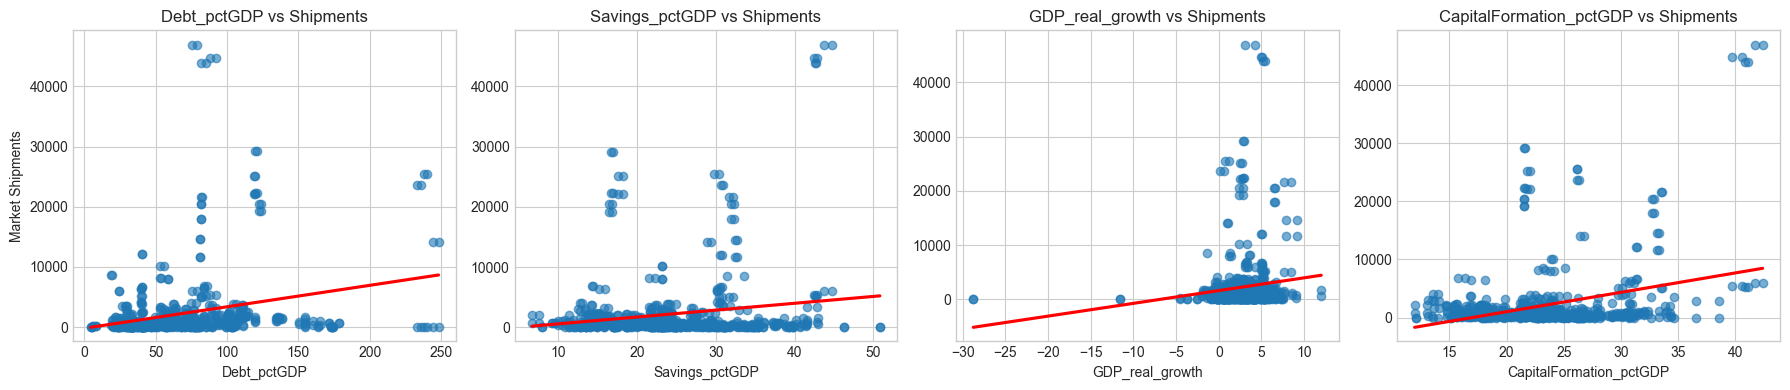

In [8]:
indicators = [
    "Debt_pctGDP",
    "Savings_pctGDP",
    "GDP_real_growth",
    "CapitalFormation_pctGDP"
]

plt.figure(figsize=(18, 4))

for i, col in enumerate(indicators, 1):
    plt.subplot(1, len(indicators), i)
    sns.regplot(
        data=train_data,
        x=col,
        y="Market Shipments",
        ci=None,
        scatter_kws={"alpha": 0.6},
        line_kws={"color": "red"}
    )
    plt.xlabel(col)
    if i == 1:
        plt.ylabel("Market Shipments")
    else:
        plt.ylabel("")
    plt.title(f"{col} vs Shipments")

plt.tight_layout()
plt.show()


In [9]:
feature_cols = indicators  # same list

X = train_data[feature_cols]
y = train_data["Market Shipments"]

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print("R²:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))

coef_df = pd.DataFrame({
    "Variable": feature_cols,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df


R²: 0.1910337023044476
MAE: 2911.8050162046356


,Variable,Coefficient
3,CapitalFormation_pctGDP,413.021671
2,GDP_real_growth,44.476261
0,Debt_pctGDP,44.319512
1,Savings_pctGDP,-27.776202


In [10]:
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:       Market Shipments   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     40.79
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           1.04e-30
Time:                        19:06:34   Log-Likelihood:                -6950.6
No. Observations:                 696   AIC:                         1.391e+04
Df Residuals:                     691   BIC:                         1.393e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -9

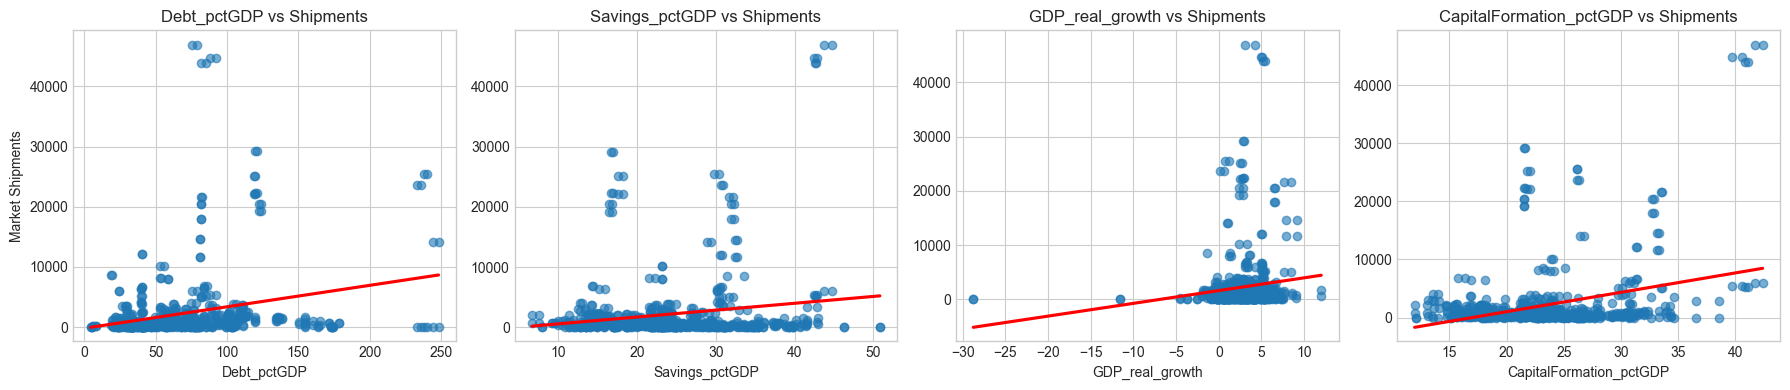

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# The 4 indicators we used in the model
indicators = [
    "Debt_pctGDP",
    "Savings_pctGDP",
    "GDP_real_growth",
    "CapitalFormation_pctGDP"
]

plt.figure(figsize=(18, 4))

for i, col in enumerate(indicators, 1):
    plt.subplot(1, len(indicators), i)
    
    # Scatter + regression line
    sns.regplot(
        data=train_data,
        x=col,
        y="Market Shipments",
        ci=None,
        scatter_kws={"alpha": 0.6},
        line_kws={"color": "red"}
    )
    
    plt.xlabel(col)
    if i == 1:
        plt.ylabel("Market Shipments")
    else:
        plt.ylabel("")
    plt.title(f"{col} vs Shipments")

plt.tight_layout()
plt.show()


In [12]:
# 1️⃣ Prepare future (2025–2030) data
future_data = data[data["Year"].between(2025, 2030)].copy()

# 2️⃣ Fill missing macro values the same way we did for training
for col in ["Debt_pctGDP", "Savings_pctGDP", "GDP_real_growth", "CapitalFormation_pctGDP"]:
    future_data[col] = future_data.groupby("Datos Region")[col].transform(
        lambda x: x.fillna(x.median())
    )

# 3️⃣ Select the same feature columns used for training
feature_cols = ["Debt_pctGDP", "Savings_pctGDP", "GDP_real_growth", "CapitalFormation_pctGDP"]
X_future = future_data[feature_cols]

# 4️⃣ Predict future Market Shipments
future_data["Predicted_Shipments"] = model.predict(X_future)

# 5️⃣ Inspect results
print(future_data[["Country", "Year", "Predicted_Shipments"]].head(10))


    Country  Year  Predicted_Shipments
6   Albania  2025          2918.405819
7   Albania  2025          2918.405819
8   Albania  2025          3046.605623
9   Albania  2025          3046.605623
10  Albania  2026          3186.040423
11  Albania  2026          3186.040423
12  Albania  2026          3207.095108
13  Albania  2026          3207.095108
14  Albania  2027          3228.991864
15  Albania  2027          3228.991864


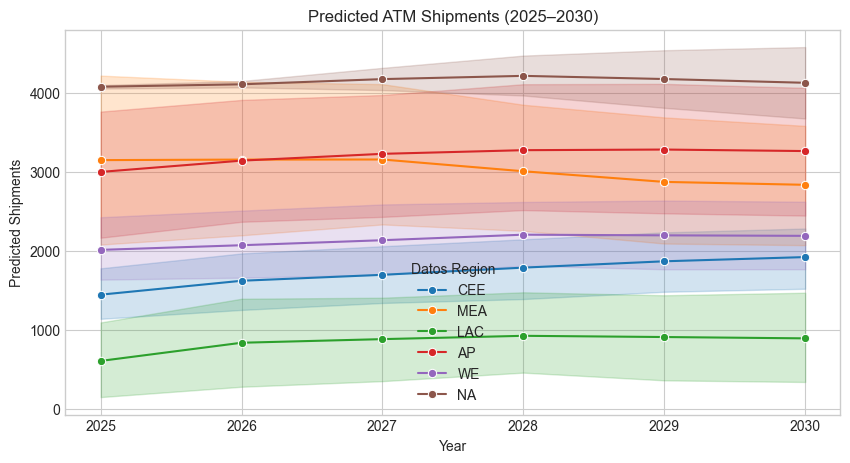

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=future_data, x="Year", y="Predicted_Shipments", hue="Datos Region", marker="o")
plt.title("Predicted ATM Shipments (2025–2030)")
plt.ylabel("Predicted Shipments")
plt.grid(True)
plt.show()


In [14]:
# Create copies to avoid modifying originals
actual = train_data.copy()
forecast = future_data.copy()

# Add label to distinguish actual vs predicted
actual["Type"] = "Actual"
forecast["Type"] = "Predicted"

# Keep same columns for merging
combined = pd.concat([actual, forecast], ignore_index=True)

print(combined[["Year", "Datos Region", "Market Shipments", "Predicted_Shipments", "Type"]].head())


   Year Datos Region  Market Shipments  Predicted_Shipments    Type
0  2022          LAC            1075.0                  NaN  Actual
1  2022          LAC             929.0                  NaN  Actual
2  2022          LAC            1075.0                  NaN  Actual
3  2022          LAC             929.0                  NaN  Actual
4  2023          LAC            1375.0                  NaN  Actual


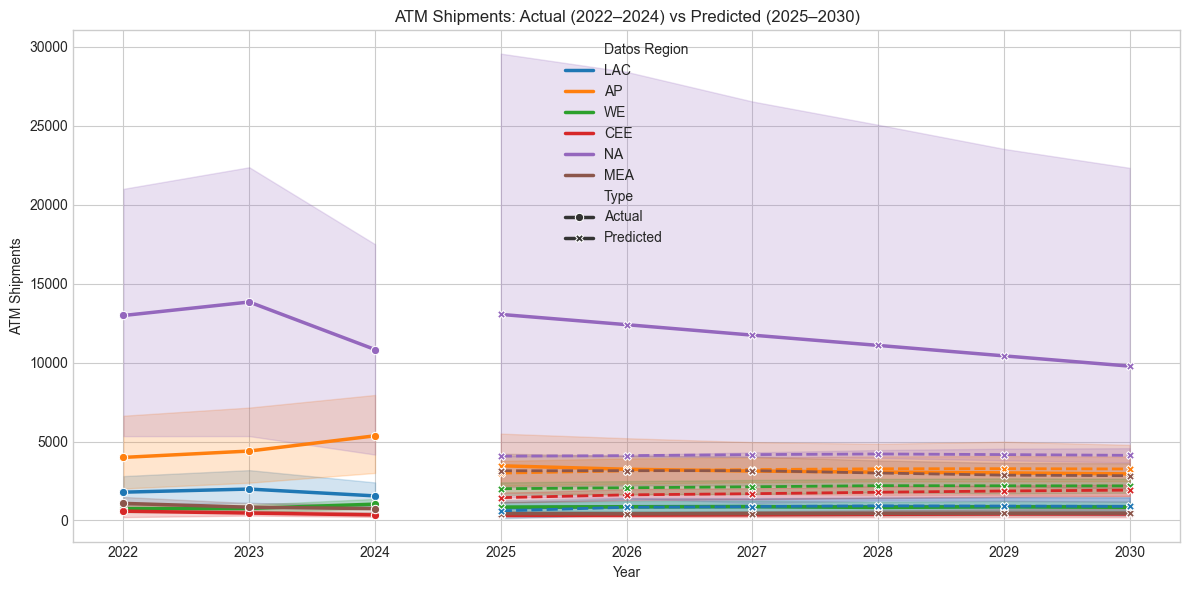

In [15]:
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=combined,
    x="Year",
    y="Market Shipments",
    hue="Datos Region",
    style="Type",
    markers=True,
    dashes=False,
    linewidth=2.5,
    palette="tab10"
)

# Overlay predicted where actual doesn't exist
sns.lineplot(
    data=combined,
    x="Year",
    y="Predicted_Shipments",
    hue="Datos Region",
    style="Type",
    markers=True,
    dashes=True,
    linewidth=2,
    legend=False,
    palette="tab10"
)

plt.title("ATM Shipments: Actual (2022–2024) vs Predicted (2025–2030)")
plt.ylabel("ATM Shipments")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# future_data is already filtered to 2025–2030
future_252030 = future_data.copy()

comparison = (
    future_252030[
        ["Country", "Datos Region", "Year",
         "Market Shipments",        # Datos forecast
         "Predicted_Shipments"]     # Model prediction
    ]
    .dropna(subset=["Market Shipments"])   # keep only where Datos forecast exists
    .copy()
)

# Rename for clarity
comparison.rename(
    columns={"Market Shipments": "Forecast_Shipments"},
    inplace=True
)

print(comparison.head())


    Country Datos Region  Year  Forecast_Shipments  Predicted_Shipments
6   Albania          CEE  2025                90.0          2918.405819
7   Albania          CEE  2025                60.0          2918.405819
8   Albania          CEE  2025                90.0          3046.605623
9   Albania          CEE  2025                60.0          3046.605623
10  Albania          CEE  2026                60.0          3186.040423


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae  = mean_absolute_error(comparison["Forecast_Shipments"],
                           comparison["Predicted_Shipments"])
rmse = np.sqrt(mean_squared_error(comparison["Forecast_Shipments"],
                                  comparison["Predicted_Shipments"]))
corr = comparison[["Forecast_Shipments", "Predicted_Shipments"]].corr().iloc[0, 1]

print(f"MAE  (|model - Datos|): {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"Correlation: {corr:.2f}")


MAE  (|model - Datos|): 3,014.90
RMSE: 5,005.78
Correlation: 0.25


In [18]:
region_summary = (
    comparison.groupby("Datos Region")[["Forecast_Shipments", "Predicted_Shipments"]]
    .mean()
    .assign(
        Diff=lambda d: d["Predicted_Shipments"] - d["Forecast_Shipments"],
        Pct_Diff=lambda d: 100 * (d["Predicted_Shipments"] - d["Forecast_Shipments"]) / d["Forecast_Shipments"]
    )
    .reset_index()
    .sort_values("Pct_Diff", ascending=False)
)

print(region_summary)


  Datos Region  Forecast_Shipments  Predicted_Shipments         Diff  \
3          MEA          443.815789          3028.238444  2584.422655   
1          CEE          370.500000          1723.517202  1353.017202   
5           WE          854.343434          2134.022141  1279.678706   
0           AP         3144.385965          3196.815641    52.429677   
2          LAC          862.222222           839.365752   -22.856470   
4           NA        11412.500000          4143.840893 -7268.659107   

     Pct_Diff  
3  582.318772  
1  365.186829  
5  149.785046  
0    1.667406  
2   -2.650879  
4  -63.690332  


C:\Users\LEGION\AppData\Local\Temp\ipykernel_14876\405978071.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


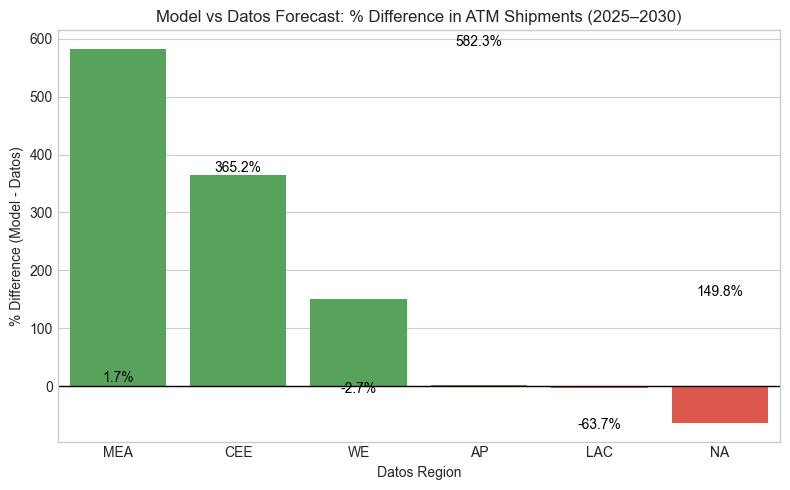

In [19]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=region_summary,
    x="Datos Region",
    y="Pct_Diff",
    palette=["#4caf50" if x > 0 else "#f44336" for x in region_summary["Pct_Diff"]]
)

plt.axhline(0, color="black", linewidth=1)
plt.title("Model vs Datos Forecast: % Difference in ATM Shipments (2025–2030)")
plt.ylabel("% Difference (Model - Datos)")
plt.xlabel("Datos Region")

# Add labels
for i, row in region_summary.iterrows():
    plt.text(i, row["Pct_Diff"] + (5 if row["Pct_Diff"] > 0 else -10),
             f"{row['Pct_Diff']:.1f}%", ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()


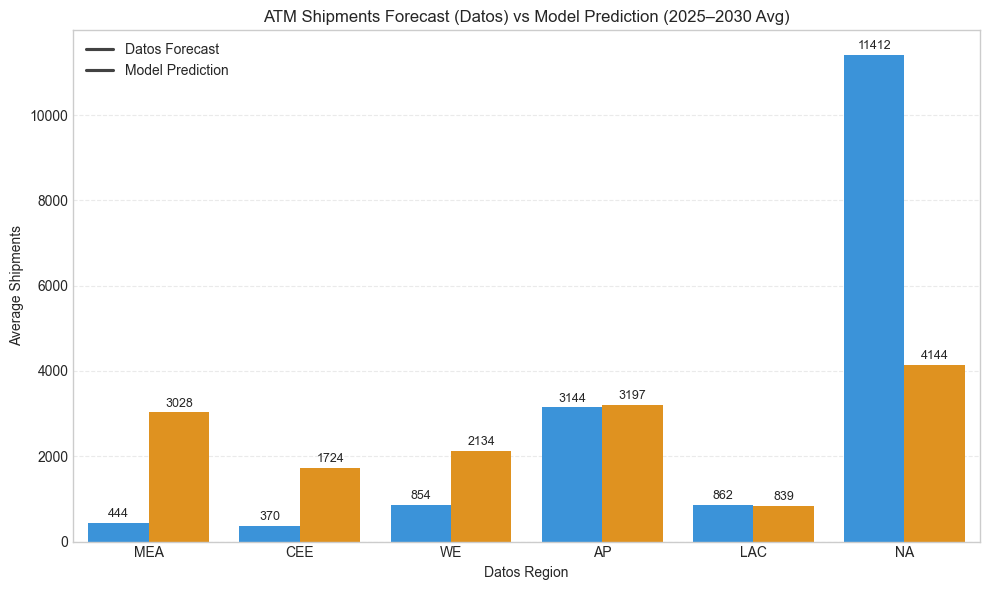

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the table so we can plot Forecast vs Predicted side-by-side
plot_df = region_summary.melt(
    id_vars="Datos Region",
    value_vars=["Forecast_Shipments", "Predicted_Shipments"],
    var_name="Type",
    value_name="Avg_Shipments"
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="Datos Region",
    y="Avg_Shipments",
    hue="Type",
    palette=["#2196f3", "#ff9800"]
)

plt.title("ATM Shipments Forecast (Datos) vs Model Prediction (2025–2030 Avg)")
plt.ylabel("Average Shipments")
plt.xlabel("Datos Region")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="", labels=["Datos Forecast", "Model Prediction"])

# Add numeric labels above bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.0f", label_type="edge", padding=2, fontsize=9)

plt.tight_layout()
plt.show()


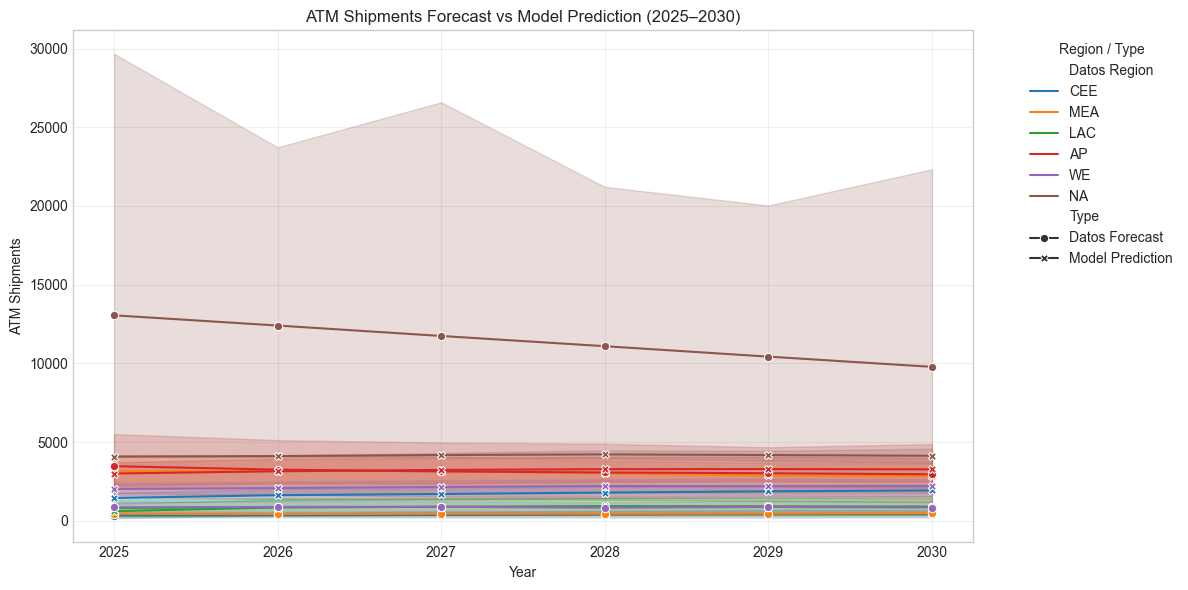

In [21]:
plt.figure(figsize=(12, 6))

# Prepare a comparison dataframe: keep only forecast years and columns
comparison_long = comparison.melt(
    id_vars=["Datos Region", "Year"],
    value_vars=["Forecast_Shipments", "Predicted_Shipments"],
    var_name="Type",
    value_name="Shipments"
)

# Map names for clarity
comparison_long["Type"] = comparison_long["Type"].map({
    "Forecast_Shipments": "Datos Forecast",
    "Predicted_Shipments": "Model Prediction"
})

# Plot line chart
sns.lineplot(
    data=comparison_long,
    x="Year",
    y="Shipments",
    hue="Datos Region",
    style="Type",
    markers=True,
    dashes=False
)

plt.title("ATM Shipments Forecast vs Model Prediction (2025–2030)")
plt.ylabel("ATM Shipments")
plt.xlabel("Year")
plt.grid(alpha=0.3)
plt.legend(title="Region / Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


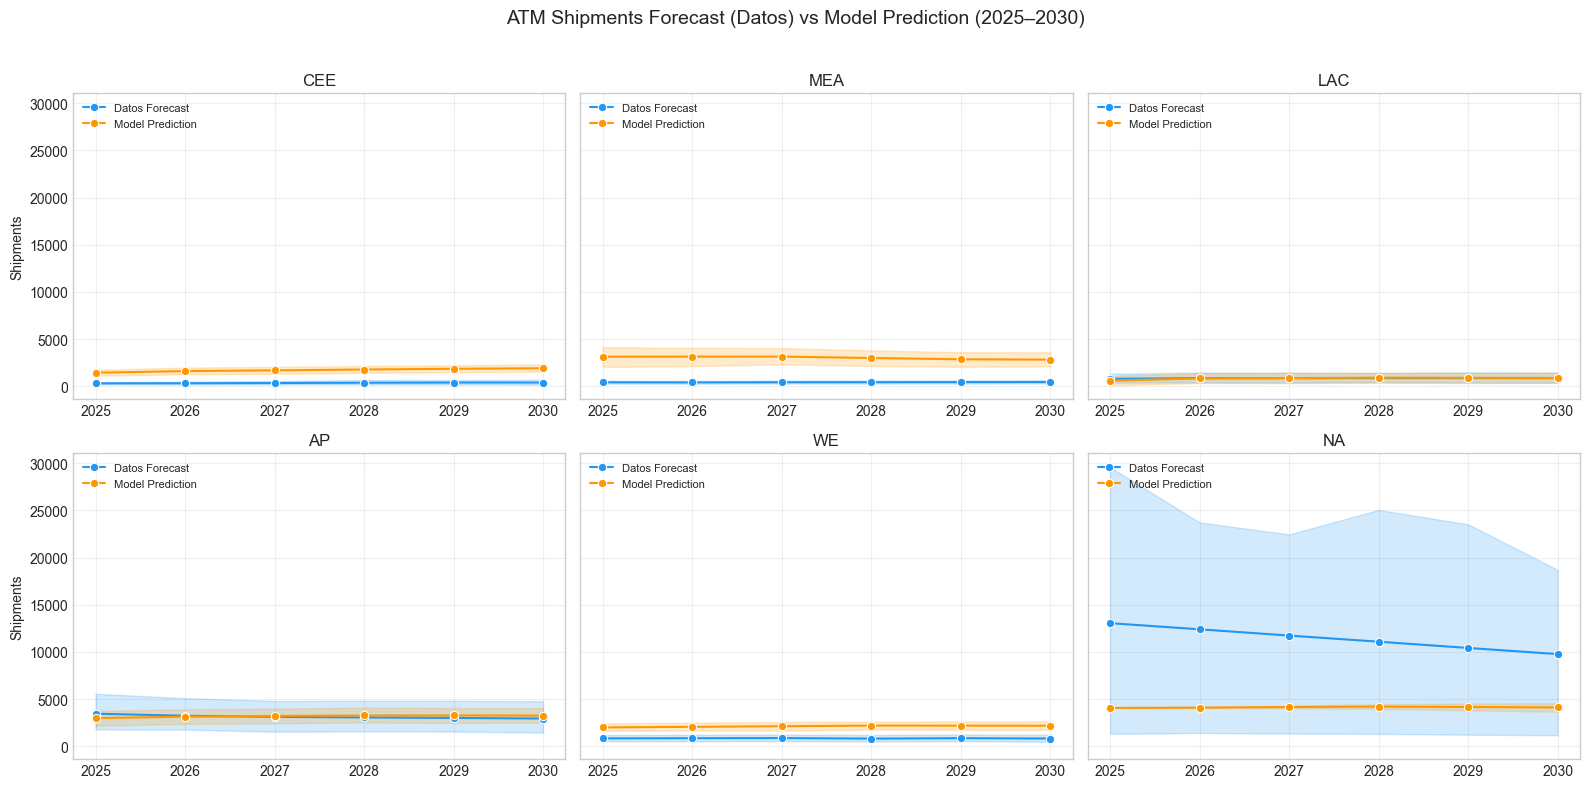

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare long-format data for plotting
comparison_long = comparison.melt(
    id_vars=["Datos Region", "Year"],
    value_vars=["Forecast_Shipments", "Predicted_Shipments"],
    var_name="Type",
    value_name="Shipments"
)

# Rename for clarity
comparison_long["Type"] = comparison_long["Type"].map({
    "Forecast_Shipments": "Datos Forecast",
    "Predicted_Shipments": "Model Prediction"
})

# Create facet-style subplots (one per region)
regions = comparison_long["Datos Region"].unique()
num_regions = len(regions)

fig, axes = plt.subplots(
    nrows=2, ncols=(num_regions + 1)//2, figsize=(16, 8), sharey=True
)

axes = axes.flatten()

for i, region in enumerate(regions):
    subset = comparison_long[comparison_long["Datos Region"] == region]
    sns.lineplot(
        data=subset,
        x="Year",
        y="Shipments",
        hue="Type",
        marker="o",
        ax=axes[i],
        palette=["#2196f3", "#ff9800"]
    )
    axes[i].set_title(region)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Shipments" if i % 3 == 0 else "")
    axes[i].grid(alpha=0.3)
    axes[i].legend(title="", loc="upper left", fontsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("ATM Shipments Forecast (Datos) vs Model Prediction (2025–2030)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [23]:
data.to_csv(r"C:\Users\LEGION\Desktop\Thesis\atm_forecast_app\data\merged_data.csv", index=False)
